# Load data from yieldmanagement RDS

In [159]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

In [160]:
import pandas as pd
import mysql.connector

In [161]:
cnx = mysql.connector.connect(user='ymdsmaster', password='YieLDMgMt36',
                              host='yieldmanagement.c2jaydssljuc.us-west-2.rds.amazonaws.com', port = 6174,
                              database='yieldmanagement')

In [4]:
cursor = cnx.cursor(buffered=True)
start_date = '2017-07-01'
end_date = '2017-12-31'
channel='ESPN'

query = (f"SELECT network_label, start_time, household_impressions, timeslot FROM yieldmanagement.rentrak_impressions where start_date BETWEEN '{start_date}' AND '{end_date}' AND network_label IN ('{channel}') ORDER BY network_label, start_time;")

cursor.execute(query)
data = pd.DataFrame(cursor.fetchall(), columns=['network_label', 'start_time', 'household_impressions', 'timeslot'])

cursor.close()

data.head()

,network_label,start_time,household_impressions,timeslot
0,ESPN,2017-07-01 00:00:00,45365,1
1,ESPN,2017-07-01 00:15:00,43367,2
2,ESPN,2017-07-01 00:30:00,42509,3
3,ESPN,2017-07-01 00:45:00,39906,4
4,ESPN,2017-07-01 01:00:00,42388,5


In [5]:
df = data.copy()
df.set_index(keys=['start_time'], drop=False,inplace=True)
df.drop(['network_label','timeslot','start_time'], axis=1,inplace=True)
print("df shape", df.shape)
print("df columns", df.columns)
values = np.log(df.values)
df.head()

df shape (17664, 1)
df columns Index(['household_impressions'], dtype='object')


,household_impressions
start_time,
2017-07-01 00:00:00,45365
2017-07-01 00:15:00,43367
2017-07-01 00:30:00,42509
2017-07-01 00:45:00,39906
2017-07-01 01:00:00,42388


In [6]:
df.head()
values.shape

(17664, 1)

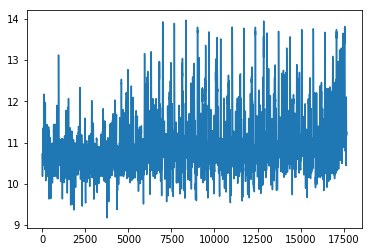

In [7]:
pyplot.plot(values)
pyplot.show()

In [8]:
# Use a subset of the series 
# series = df[:500]

# use all data
series = df


# Multistep LSTM regression

https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

In [9]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras

/home/ec2-user/anaconda3/envs/lstm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [173]:
# fix random seed for reproducibility
numpy.random.seed(7)

n_lag = 30*96
n_seq = 3*96
n_test = 8

# Easier for stateful LSTM
n_batch =1 

nb_epoch = 2
n_neuron = 128

In [11]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
# normalize the dataset
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values

    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test
    

In [13]:
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

/home/ec2-user/anaconda3/envs/lstm/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [169]:
# reshape training into [samples, timesteps, features]
X, y = train[:, 0:n_lag], train[:, n_lag:]
X = X.reshape(X.shape[0], 1, X.shape[1])

In [170]:
# create an LSTM network to training data
def create_lstm(X, y, n_lag, n_seq, n_batch, n_neurons):
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [171]:
def fit_lstm(nb_epoch, model, n_batch):
    # fit network - reset state between epochs
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()

In [172]:
# create or load model
#model = create_lstm(X, y, n_lag, n_seq, n_batch, n_neuron)

from keras.models import load_model
model = load_model('multistep-lstm-rentrak.h5')


In [174]:
fit_lstm(nb_epoch, model, n_batch)

Epoch 1/1
14489/14489 [==============================] - 547s 38ms/step - loss: 0.0403
Epoch 1/1
14489/14489 [==============================] - 546s 38ms/step - loss: 0.0419


In [176]:
# save model
model.save('multistep-lstm-rentrak.h5')

In [200]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    model.reset_states()
    # convert to array
    return [x for x in forecast[0, :]]

In [201]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [211]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [212]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler):
    inverted = list()
    
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]

        # store
        inverted.append(inv_scale)
    return inverted

In [213]:
# inverse transform forecasts and test
rescaled_forecasts = inverse_transform(series, forecasts, scaler)

In [214]:
actual_forecasts = [row[n_lag:] for row in test]
rescaled_actual_forecasts = inverse_transform(series, actual_forecasts, scaler)

In [215]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    errors = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        
        errors.append(rmse)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        
    return errors

In [216]:
# evaluate forecasts
errors = evaluate_forecasts(rescaled_actual_forecasts, rescaled_forecasts, n_lag, n_seq)



t+1 RMSE: 108308.098487
t+2 RMSE: 139062.443388
t+3 RMSE: 151765.830130
t+4 RMSE: 220056.527339
t+5 RMSE: 245455.225758
t+6 RMSE: 307815.063753
t+7 RMSE: 321066.720844
t+8 RMSE: 360405.566687
t+9 RMSE: 383336.103016
t+10 RMSE: 377514.868832
t+11 RMSE: 408654.063560
t+12 RMSE: 419684.243543
t+13 RMSE: 419182.714815
t+14 RMSE: 380653.640757
t+15 RMSE: 426408.258847
t+16 RMSE: 376422.757767
t+17 RMSE: 350442.526267
t+18 RMSE: 318148.042904
t+19 RMSE: 284311.426762
t+20 RMSE: 265250.308490
t+21 RMSE: 259321.791072
t+22 RMSE: 226986.278525
t+23 RMSE: 174424.728513
t+24 RMSE: 188871.370895
t+25 RMSE: 157068.461318
t+26 RMSE: 170418.387307
t+27 RMSE: 124421.645485
t+28 RMSE: 71324.923825
t+29 RMSE: 66261.124630
t+30 RMSE: 56613.052362
t+31 RMSE: 53451.595697
t+32 RMSE: 52983.303502
t+33 RMSE: 25611.540870
t+34 RMSE: 30240.372531
t+35 RMSE: 18965.240498
t+36 RMSE: 17766.514210
t+37 RMSE: 14860.812801
t+38 RMSE: 23698.167281
t+39 RMSE: 17796.888527
t+40 RMSE: 27355.767639
t+41 RMSE: 16680.79630

In [217]:
df_errors2 = pd.DataFrame(errors, columns=['2 epoch errors'])

df_more_errors = pd.concat([df_errors, df_errors2], axis=1)

df_more_errors

,1 epoch errors,2 epoch errors
0,158850.328802,108308.098487
1,134407.904708,139062.443388
2,150315.014098,151765.830130
3,148477.545117,220056.527339
4,337247.506123,245455.225758
5,296906.662699,307815.063753
6,380827.175718,321066.720844
7,347446.603867,360405.566687
8,333032.513305,383336.103016
9,429602.335685,377514.868832


In [218]:
%matplotlib inline
pyplot.rcParams['figure.figsize'] = (16, 12)

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):

    # plot the entire dataset in blue
    pyplot.plot(series.values)
    
    
    # plot the forecasts in red
#     for i in range(len(forecasts)):
#     for i in [0, 4]:
#         print(f'forecasts[{i}].shape: {forecasts[i].shape}')
    
    i = 0
    off_s = len(series) - n_test + i - 1
    off_e = off_s + len(forecasts[i]) 

#         print(f'off_s: {off_s}; off_e: {off_e}')
    xaxis = [x for x in range(off_s, off_e)]
#         print(f'xaxis[0]: {xaxis[0]}')

#         print(f'series.values[{off_s}]: {series.values[off_s]}')
#         print(f'first forecasted value: {series.values[off_s] + forecasts[i][0]}')    
    yaxis = forecasts[i].T
#         print(f'yaxis[0]: {yaxis[0]}')

    pyplot.plot(xaxis, yaxis, color='red')

    i = 1
    off_s = len(series) - n_test + i - 1
    off_e = off_s + len(forecasts[i]) 

#         print(f'off_s: {off_s}; off_e: {off_e}')
    xaxis = [x for x in range(off_s, off_e)]
#         print(f'xaxis[0]: {xaxis[0]}')

#         print(f'series.values[{off_s}]: {series.values[off_s]}')
#         print(f'first forecasted value: {series.values[off_s] + forecasts[i][0]}')    
    yaxis = forecasts[i].T
#         print(f'yaxis[0]: {yaxis[0]}')

    pyplot.plot(xaxis, yaxis, color='green')

    i = 2
    off_s = len(series) - n_test + i - 1
    off_e = off_s + len(forecasts[i]) 

#         print(f'off_s: {off_s}; off_e: {off_e}')
    xaxis = [x for x in range(off_s, off_e)]
#         print(f'xaxis[0]: {xaxis[0]}')

#         print(f'series.values[{off_s}]: {series.values[off_s]}')
#         print(f'first forecasted value: {series.values[off_s] + forecasts[i][0]}')    
    yaxis = forecasts[i].T
#         print(f'yaxis[0]: {yaxis[0]}')

    pyplot.plot(xaxis, yaxis, color='yellow')



    i = 4
    off_s = len(series) - n_test + i - 1
    off_e = off_s + len(forecasts[i]) 

#         print(f'off_s: {off_s}; off_e: {off_e}')
    xaxis = [x for x in range(off_s, off_e)]
#         print(f'xaxis[0]: {xaxis[0]}')

#         print(f'series.values[{off_s}]: {series.values[off_s]}')
#         print(f'first forecasted value: {series.values[off_s] + forecasts[i][0]}')    
    yaxis = forecasts[i].T
#         print(f'yaxis[0]: {yaxis[0]}')

    pyplot.plot(xaxis, yaxis, color='orange')

        
    # show the plot
    pyplot.show()

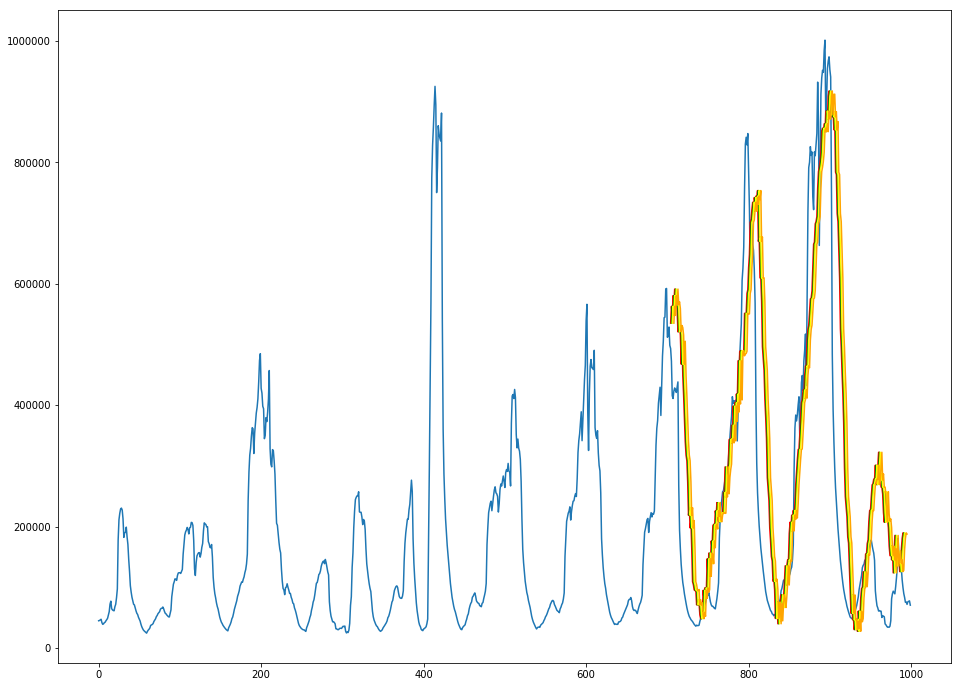

In [219]:

# plot forecasts
plot_forecasts(series[-1000:], rescaled_forecasts, n_test + n_seq -1)

In [97]:
# Try 3D ribbon graph using plot.ly

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

init_notebook_mode(connected=True)


2.4.0


In [220]:
# Plot errors

# Create a trace
name = '1 epoch errors'
trace1 = go.Scatter(
    x = np.array(range(len(errors))),
    y = df_more_errors[name],
    name = name
    
)

name = '2 epoch errors'
trace2 = go.Scatter(
    x = np.array(range(len(errors))),
    y = df_more_errors[name],
    name = name

)

data = [trace1, trace2]

iplot(data)

In [221]:
np.mean(df_more_errors)

1 epoch errors    182691.082501
2 epoch errors    177894.363431
dtype: float64